<a href="https://colab.research.google.com/github/AlexCHEN-Engineer/CEE314HW/blob/main/CEE314Problemsets5Q4Teaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# Do not revise here. 
try:
    import google.colab
except ImportError:
    import ufl
    import dolfin
    import mshr
else:
    try:
        import ufl
        import dolfin
        import mshr
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl
        import dolfin
        import mshr

# Variational formulation

In this part, we will solve a coupled poromechanics problems.

For a domain denoted as $\Omega$, the boundary is $\Gamma = \Gamma_u\cup \Gamma_t = \Gamma_p\cup\Gamma_q$, $\Gamma_u\cap \Gamma_t=\phi$ and $\Gamma_p\cup\Gamma_q=\phi$. 

The strong form can be expressed as:
\begin{equation}
\begin{aligned}
&\nabla\cdot(\boldsymbol{\sigma}^\prime-p\boldsymbol{1})+\rho\boldsymbol{g}=\boldsymbol{0},   \\
&\nabla⋅\dot{\boldsymbol{u}}+\nabla⋅{\boldsymbol{q}}=0, \\
& \boldsymbol{u} = \overline{\boldsymbol{u}}\quad on \quad \Gamma_u, \\
& \boldsymbol{\sigma}^\prime\cdot\boldsymbol{n} = \overline{\boldsymbol{t}}\quad on\quad \Gamma_t, \\
& p = \overline{p}\quad on \quad \Gamma_p, \\
& \boldsymbol{q}\cdot \boldsymbol{n} = \overline{q}\quad on \quad \Gamma_q.
\end{aligned}
\end{equation}

As for the constitutive equations, we need to refer to
\begin{equation}
\begin{aligned}
& \boldsymbol{\sigma}^\prime = \mathbb{C}^e:\boldsymbol{\epsilon} ,\\
& \boldsymbol{q} = -\frac{\boldsymbol{\kappa}}{\mu_f}\cdot \nabla p.
\end{aligned}
\end{equation}


## Derive the weak form

The trial space is defined as 
\begin{equation}
\begin{aligned}
& S_u = \{\boldsymbol{u}:\Omega→\mathbb{R}^{ndim}|\boldsymbol{u}→\boldsymbol{H}^1,\ \boldsymbol{u}=\overline{\boldsymbol{u}}\quad on \quad \Gamma_u \} ,\\
&S_p = \{p:\Omega→\mathbb{R}|p→H^1,\ p=\overline{p}\quad on \quad \Gamma_p \}
\end{aligned}
\end{equation}

For the weighting space,
\begin{equation}
\begin{aligned}
& V_u = \{\boldsymbol{\eta}:\Omega→\mathbb{R}^{ndim}|\boldsymbol{\eta}→\boldsymbol{H}^1,\ \boldsymbol{\eta}={\boldsymbol{0}}\quad on \quad \Gamma_u \} ,\\
&V_\psi = \{\psi:\Omega→\mathbb{R}|\psi→H^1,\ \psi=0\quad on \quad \Gamma_\psi \}
\end{aligned}
\end{equation}


The weak form becomes:
\begin{equation}
\begin{aligned}
& \mathcal{G}_1 = \int_{\Omega}(\nabla^s\boldsymbol{\eta}:\boldsymbol{\sigma}^\prime-p\nabla\cdot\boldsymbol{\eta}-\boldsymbol{\eta}\cdot{\rho}\boldsymbol{g})dV - \int_{\Gamma_t}\boldsymbol{\eta}\cdot\overline{\boldsymbol{t}}dA = \boldsymbol{0} \\
& \mathcal{G}_2 = \int_{\Omega}(\psi\nabla\cdot\dot{\boldsymbol{u}}-\nabla \psi\cdot \boldsymbol{q})dV + \int_{\Gamma_q} \psi\bar{q}dA\\
\end{aligned}
\end{equation}

# Import necessary library

In [ ]:
from fenics import *
from mshr import *
from ufl import nabla_div

# Parameters

For the conversion between elastic modulus, refer to this [wiki page](https://en.wikipedia.org/wiki/Elastic_modulus).

In [ ]:
##############################
## TODO: Set the parameters ##
##############################
# You need to set different parameters to run the simulation!
# T = 1
# num_steps = 100

dt = T / (1.0*num_steps) #time step size

rho_l = 1000

E = 10.e7 #Pa
nu = 0
k = 1.15740741e-10 	#intrinsic permeability
mu_l = 1e-2 	#dynamic viscosity

lambda_= E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu);

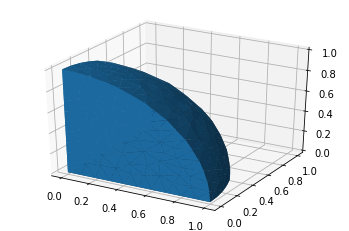

In [ ]:
# Create mesh and define expression
# Parameters
R = 1.
# Create geometry
s = Sphere(Point(0, 0, 0), 1)
# s2 = Sphere(Point(x, y, z), r)
b1 = Box(Point(0., 0., 0.), Point(1., 1., 1.))
geometry = s*b1
# Create mesh
mesh = generate_mesh(geometry, 15)
plot(mesh)

In [ ]:
outer =  CompiledSubDomain("x[0]*x[0] + x[1]*x[1] + x[2]*x[2] > 0.9")
cutX =  CompiledSubDomain("near(x[0], side)", side = 0.0)
cutY =  CompiledSubDomain("near(x[1], side)", side = 0.0)
cutZ = CompiledSubDomain("near(x[2], side)", side = 0.0)

boundary = MeshFunction('size_t', mesh, mesh.topology().dim()-1)
boundary.set_all(1)
outer.mark(boundary, 2)
ds = Measure('ds', domain = mesh, subdomain_data = boundary)


T  = 100 * Expression(('-x[0]', '-x[1]','-x[2]'), degree=1)  # Load on the boundary

#Define Mixed Space (R2,R) -> (u,p)
V = VectorElement("CG", mesh.ufl_cell(), 2)
W = FiniteElement("CG", mesh.ufl_cell(), 1)
L = FunctionSpace(mesh,W)
MS = dolfin.FunctionSpace(mesh, MixedElement([V,W]))

# Define boundary condition
bcu1 = DirichletBC(MS.sub(0).sub(0), 0.0, cutX)  # slip condition
bcu2 = DirichletBC(MS.sub(0).sub(1), 0.0, cutY)  # slip condition
bcu3 = DirichletBC(MS.sub(0).sub(2), 0.0, cutZ)  # slip condition
bcp = DirichletBC(MS.sub(1), 0.0, outer) # drained condition
bc=[bcu1,bcu2,bcu3,bcp]

# Define strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

def sigma(u):
   return lambda_ * tr(epsilon(u))*Identity(3) + 2.0*mu*epsilon(u)

# Define variational problem and initial condition
X0 = Function(MS)
B = TestFunction(MS)

e_u0 = Expression(('0.0', '0.0', '0.0'), degree=1)
e_p0 = Expression('0.0', degree=1)

u0 = interpolate(e_u0, MS.sub(0).collapse())
p0 = interpolate(e_p0, MS.sub(1).collapse())

Xn = Function(MS)
assign(Xn, [u0, p0])

(u, p)=split(X0)
(u_n, p_n)=split(Xn)
(v, q)=split(B)

# n = FacetNormal(mesh)

F = nabla_div(u-u_n)*q*dx + dt*(k/(mu_l))*dot(grad(p), grad(q))*dx 
F += inner(sigma(u), epsilon(v))*dx  - p*nabla_div(v)*dx - dot(T,v)*ds(2)


#solver tuning
dX0 = TrialFunction(MS)
J = derivative(F, X0, dX0)
Problem = NonlinearVariationalProblem(F, X0, J = J, bcs = bc)
Solver  = NonlinearVariationalSolver(Problem)
Solver.parameters['newton_solver']['convergence_criterion'] = 'incremental'
Solver.parameters['newton_solver']['relative_tolerance'] = 1.e-11
Solver.parameters['newton_solver']['absolute_tolerance'] = 5.e-10

#if you want to store the results
#vtkfile_u = File('Sphere/u.pvd')
#vtkfile_p = File('Sphere/p.pvd')

t = 0

p_out = []

from tqdm import tqdm_notebook
for n in tqdm_notebook(range(num_steps)):
	t += dt
	Solver.solve()    
	assign(Xn,X0)

	(_u,_p)=X0.split()
	p_out.append(_p(0, 0, 0))
	#vtkfile_u << (_u,t)
	#vtkfile_p << (_p,t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

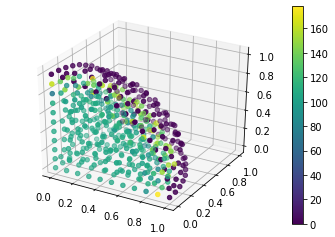

In [ ]:
u_result, p_result = X0.split()
import matplotlib.pyplot as plt
c=plot(p_result)
plt.colorbar(c)
plt.show()

# Postprocess

In [ ]:
# Use the following method to zip the file.
!zip -r 'Sphere.zip' '/content/Sphere' 

updating: content/Sphere/ (stored 0%)
updating: content/Sphere/u.pvd (deflated 29%)
updating: content/Sphere/u000000.vtu (deflated 63%)
updating: content/Sphere/p000000.vtu (deflated 64%)
updating: content/Sphere/p.pvd (deflated 29%)


## 4(b)

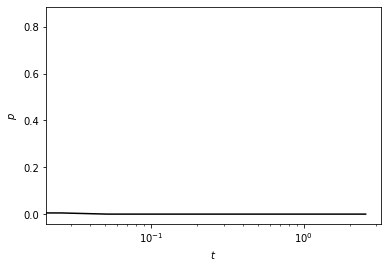

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
time = np.linspace(0,1,100)
pressure = np.array(p_out)
plt.xlabel(r"$t$")
plt.ylabel(r"$p$")
plt.semilogx(100/9.8*1*time/4, pressure, 'k')